In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Formulas have been taken from lecture slides.

LDA:
1. Calculate the assumed common covariance matrix
2. Calculate the means for each of the two classes
3. Plug into the formula $f_{kl}(x)=wx+b$, when $f(x) < 0$, predicted class: $l$, else predicted class: $k$
    1. $w=(\mu_k-\mu_l)^T\Sigma^{-1}$
    2. $b=-\frac{1}{2}(\mu_k\mu_l)^T\Sigma^{-1}(\mu_k+\mu_l)+log\frac{N_k}{N_l}$
    
QDA:
1. Calculate the covariance matrix for each of the two classes
2. Calculate the means for each of the two classes
3. Plug into the formula $f(x)=sign(w^Tx+b)$
    1. $w=\Sigma^{-1}(\mu_1-\mu_{-1})$
    2. $b=\frac{1}{2}(\mu_{-1}+\mu_1)^T\Sigma^{-1}(\mu_{-1}-\mu_1)+log\frac{N_1}{N_{-1}}$
    

In [85]:
class LDA:
    def __init__(self):
        self.w=0
        self.b=0
        self.mean_0=0
        self.mean_1=0
        self.covariance_matrix=0

    def fit(self,X,y):
        classes= np.unique(y)
        self.covariance_matrix = np.cov(X[y==classes[0]].T)
        self.mean_0=np.mean(X[y==classes[0]], axis=0)
        self.mean_1=np.mean(X[y==classes[1]], axis=0)

        covariance_matrix_inverse = np.linalg.inv(self.covariance_matrix)
        no_0 = (y==classes[0]).sum()
        no_1=(y==classes[1]).sum()
        # class 0 being class k, and class 1 being class l
        self.w=(self.mean_0-self.mean_1).T.dot(covariance_matrix_inverse)
        self.b=-(1/2)*(self.mean_0-self.mean_1).T.dot(covariance_matrix_inverse).dot((self.mean_0+self.mean_1))+np.log(no_0/no_1)

        
    def predict_proba(self, Xtest):
        f = self.w.dot(Xtest)+self.b
        # print("Predicted: ",f)
        return f
    def predict(self, Xtest):
        f = np.sign(self.w.dot(Xtest)+self.b)
        # print("Predicted class: ",1 if f==-1 else 0)
        return 1 if f==-1 else 0
    def get_params(self):
        print("w: ",self.w ,"\nb: ",self.b, "\nm_0: ",self.mean_0, "\nm_1: ",self.mean_1,"\ncovariance matrix: ",self.covariance_matrix)
        return (self.w, self.b,self.mean_0,self.mean_1,self.covariance_matrix)
    
class QDA:
    def fit(X,y):
        return NotImplementedError
    def predict_proba(Xtest):
        return NotImplementedError
    def predict(Xtest):
        return NotImplementedError
    def get_params():
        return NotImplementedError
    

class NB:
    def fit(X,y):
        return NotImplementedError
    def predict_proba(Xtest):
        return NotImplementedError
    def predict(Xtest):
        return NotImplementedError
    def get_params():
        return NotImplementedError
    



#### Data generation

In [65]:
def scheme_1_data_generator(a):
    n=1000
    bern_prob=0.5
    y=np.random.binomial(size=n, n=1, p= bern_prob)
    feature_0_0 = np.random.normal(0, 1, size=(1, n)).T
    feature_0_1 = np.random.normal(0, 1, size=(1, n)).T
    feature_0=np.hstack([feature_0_0,feature_0_1])

    feature_1_0 = np.random.normal(a, 1, size=(1, n)).T
    feature_1_1 = np.random.normal(a, 1, size=(1, n)).T
    feature_1=np.hstack([feature_1_0,feature_1_1])
    
    X = np.concatenate((feature_0[y==0],feature_1[y==1]))
    return (X,y)
def scheme_2_data_generator(mean,rho):
    n=1000
    bern_prob=0.5
    y=np.random.binomial(size=n, n=1, p= bern_prob)
    # cov(X,Y) = corr(X,Y)*std(X)*std(Y)
    features_0 = np.random.multivariate_normal([0,0], [[1,rho],[rho,1]], n)
    features_1 = np.random.multivariate_normal([mean,mean], [[1,-rho],[-rho,1]], n)
    X = np.concatenate((features_0[y==0],features_1[y==1]))
    return (X,y)


#### Accuracy

In [94]:
def get_accuracy(model:LDA|QDA|NB,X_test,y_test):
    correct=0
    index =0
    for x in X_test:
        result=model.predict(x)
        if result==y_test[index]:
            correct=correct + 1
        index = index + 1
    return correct/len(y_test)

### Comparison #1

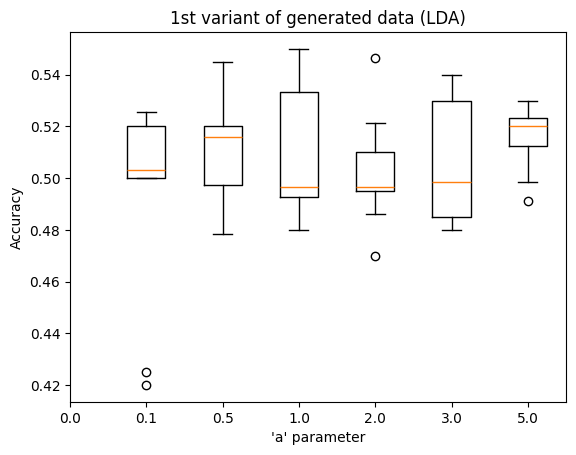

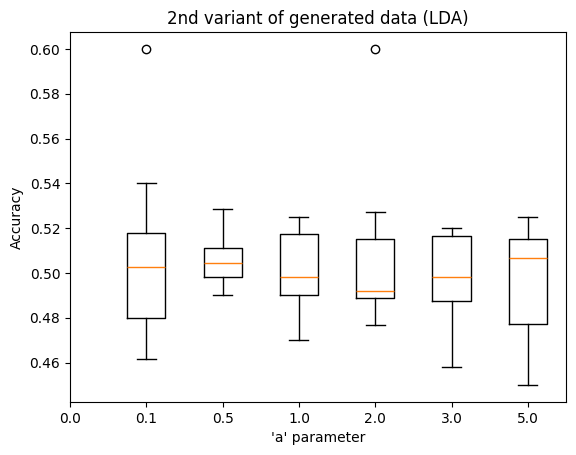

In [117]:
lda=LDA()
# scheme_2_data_generator(1,0.5)
splits = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
a_params = [0.1,0.5,1,2,3,5]
accuracies_scheme_1=[]
accuracies_scheme_2=[]
for a in a_params:
    accuracy_scheme_1=[]
    accuracy_scheme_2=[]
    for x in splits:
        (X,y)=scheme_1_data_generator(a)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)
        accuracy_scheme_1.append(get_accuracy(lda,X_test,y_test))
        (X,y)=scheme_2_data_generator(a,0.5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)
        accuracy_scheme_2.append(get_accuracy(lda,X_test,y_test))
    accuracies_scheme_1.append(accuracy_scheme_1)
    accuracies_scheme_2.append(accuracy_scheme_2)

plt.boxplot(accuracies_scheme_1)
plt.xticks(list(range(len(a_params)+1)),np.concatenate(([0],a_params)))
plt.title("1st variant of generated data (LDA)")
plt.ylabel("Accuracy")
plt.xlabel("'a' parameter")
plt.show()        
plt.boxplot(accuracies_scheme_2)
plt.xticks(list(range(len(a_params)+1)),np.concatenate(([0],a_params)))
plt.title("2nd variant of generated data (LDA)")
plt.ylabel("Accuracy")
plt.xlabel("'a' parameter")
plt.show() 